In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import preprocessing
import matplotlib.pyplot as plt

data = pd.DataFrame()
#read the input csv 
rank_data = pd.read_csv("conjoint_bike.csv")
rank_data

,Rank,gear,type,susp,guards
0,1,Has_gears,Mountain_bike,Suspension,Mudguards
1,2,No_gears,Mountain_bike,Suspension,Mudguards
2,3,Has_gears,Racing_bike,Suspension,Mudguards
3,4,No_gears,Racing_bike,Suspension,Mudguards
4,5,Has_gears,Mountain_bike,No_Suspension,Mudguards
5,6,No_gears,Mountain_bike,No_Suspension,Mudguards
6,7,Has_gears,Mountain_bike,Suspension,No_mudguards
7,8,No_gears,Mountain_bike,Suspension,No_mudguards
8,9,Has_gears,Racing_bike,No_Suspension,Mudguards
9,10,No_gears,Racing_bike,No_Suspension,Mudguards


In [2]:
#list(conjoint_data.columns)

In [3]:
#introduce dummy variables 
conjoint_data = pd.get_dummies(rank_data,columns =['gear','type','susp','guards'])

conjoint_data = conjoint_data.drop(['gear_No_gears', 'type_Mountain_bike',  'susp_No_Suspension', 'guards_No_mudguards'], axis=1)

cols = list(conjoint_data.columns)
conjoint_data

,Rank,gear_Has_gears,type_Racing_bike,susp_Suspension,guards_Mudguards
0,1,1,0,1,1
1,2,0,0,1,1
2,3,1,1,1,1
3,4,0,1,1,1
4,5,1,0,0,1
5,6,0,0,0,1
6,7,1,0,1,0
7,8,0,0,1,0
8,9,1,1,0,1
9,10,0,1,0,1


In [4]:
y = conjoint_data['Rank']
X = conjoint_data.drop('Rank', axis=1)
X['const'] = 1

linearRegression = sm.OLS(y, X).fit()
linearRegression.summary()

E:\anaconda3\envs\py37\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Rank   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.9380
Date:                Tue, 27 Oct 2020   Prob (F-statistic):              0.477
Time:                        12:36:01   Log-Likelihood:                -36.134
No. Observations:                  16   AIC:                             82.27
Df Residuals:                      11   BIC:                             86.13
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
gear_Has_gears      -0.7500      1.396     -0.537      0.602      -3.823       2.323
type_Racing_bike     0.5000      1.396      0.358      0.727      -2.573       3.573
susp_Suspension     -2.5000      1.396     -1.791      0.101      -5.573       0.573
guards_Mudguards     0.5000      1.396      0.358      0.727      -2.573       3.573
const                5.8750      1.561      3.764      0.003       2.440       9.310
==============================================================================
Omnibus:                        3.357   Durbin-Watson:                   0.740
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                2.586
Skew:                           0.933   Prob(JB):                        0.274
Kurtosis:                       2.371   Cond. No.                         4.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
lp = linearRegression.params
pars = pd.DataFrame({'var':lp.index, 'coeft':lp.values})
pars               

,var,coeft
0,gear_Has_gears,-0.750
1,type_Racing_bike,0.500
2,susp_Suspension,-2.500
3,guards_Mudguards,0.500
4,const,5.875


In [6]:
df2 = pd.get_dummies(rank_data.loc[:, ['gear','type','susp','guards']], columns =['gear','type','susp','guards'])
cols = list(df2.columns)

df3 = pd.DataFrame()
df3['var'] = cols

In [7]:
df3 = df3.merge(pars, on='var', how='left')
df3=df3.fillna(0)

In [8]:
df3['attrib']= df3["var"].str.split("_", n = 1, expand=True)[0]
df3['factors']= df3["var"].str.split("_", n = 1, expand=True)[1]

In [9]:
df3

,var,coeft,attrib,factors
0,gear_Has_gears,-0.75,gear,Has_gears
1,gear_No_gears,0.00,gear,No_gears
2,type_Mountain_bike,0.00,type,Mountain_bike
3,type_Racing_bike,0.50,type,Racing_bike
4,susp_No_Suspension,0.00,susp,No_Suspension
5,susp_Suspension,-2.50,susp,Suspension
6,guards_Mudguards,0.50,guards,Mudguards
7,guards_No_mudguards,0.00,guards,No_mudguards


In [10]:
attrib = df3.groupby('attrib')['coeft'].agg(['min', 'max'])
attrib['imp'] = attrib['max'] - attrib['min']
attrib['imp%'] = attrib['imp']*100/(attrib['imp'].sum())
attrib = attrib.sort_values(['imp%'],ascending=False)
attrib

,min,max,imp,imp%
attrib,,,,
susp,-2.50,0.0,2.50,58.823529
gear,-0.75,0.0,0.75,17.647059
type,0.00,0.5,0.50,11.764706
guards,0.00,0.5,0.50,11.764706


<AxesSubplot:xlabel='attrib'>

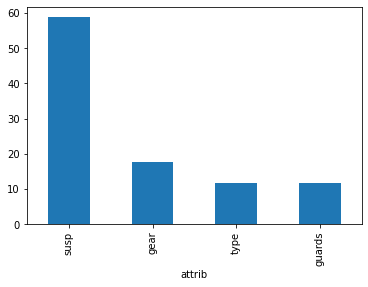

In [11]:
attrib['imp%'].plot.bar()

In [12]:
list1 = ['Has_gears', 'No_gears'] 
list2 = ['Mountain_bike', 'Racing_bike'] 
list3 = ['Suspension', 'No_Suspension'] 
list4 = ['Mudguards', 'No_mudguards'] 

factors = [[i, j, k, l] for i in list1  
                 for j in list2 
                 for k in list3
                 for l in list4] 

In [13]:
df = pd.DataFrame(factors, columns =['gear','type','susp','guards'])
df

,gear,type,susp,guards
0,Has_gears,Mountain_bike,Suspension,Mudguards
1,Has_gears,Mountain_bike,Suspension,No_mudguards
2,Has_gears,Mountain_bike,No_Suspension,Mudguards
3,Has_gears,Mountain_bike,No_Suspension,No_mudguards
4,Has_gears,Racing_bike,Suspension,Mudguards
5,Has_gears,Racing_bike,Suspension,No_mudguards
6,Has_gears,Racing_bike,No_Suspension,Mudguards
7,Has_gears,Racing_bike,No_Suspension,No_mudguards
8,No_gears,Mountain_bike,Suspension,Mudguards
9,No_gears,Mountain_bike,Suspension,No_mudguards


In [14]:
df4 = df3.loc[:, ['factors', 'coeft']]

for fs in ['gear','type','susp','guards']:
    #df2 = df[[fs]]
    df5 = df4.rename(columns = {'coeft': str('coef_'+fs),'factors':fs})
    df = df.merge(df5, on=fs)
    
print(df)

         gear           type           susp        guards  coef_gear  \
0   Has_gears  Mountain_bike     Suspension     Mudguards      -0.75   
1    No_gears  Mountain_bike     Suspension     Mudguards       0.00   
2   Has_gears    Racing_bike     Suspension     Mudguards      -0.75   
3    No_gears    Racing_bike     Suspension     Mudguards       0.00   
4   Has_gears  Mountain_bike  No_Suspension     Mudguards      -0.75   
5    No_gears  Mountain_bike  No_Suspension     Mudguards       0.00   
6   Has_gears    Racing_bike  No_Suspension     Mudguards      -0.75   
7    No_gears    Racing_bike  No_Suspension     Mudguards       0.00   
8   Has_gears  Mountain_bike     Suspension  No_mudguards      -0.75   
9    No_gears  Mountain_bike     Suspension  No_mudguards       0.00   
10  Has_gears    Racing_bike     Suspension  No_mudguards      -0.75   
11   No_gears    Racing_bike     Suspension  No_mudguards       0.00   
12  Has_gears  Mountain_bike  No_Suspension  No_mudguards      -

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gear         16 non-null     object 
 1   type         16 non-null     object 
 2   susp         16 non-null     object 
 3   guards       16 non-null     object 
 4   coef_gear    16 non-null     float64
 5   coef_type    16 non-null     float64
 6   coef_susp    16 non-null     float64
 7   coef_guards  16 non-null     float64
dtypes: float64(4), object(4)
memory usage: 1.1+ KB


In [16]:
df['Tot_utils'] = df.loc[:,['coef_gear', 'coef_type', 'coef_susp', 'coef_guards']].sum(axis=1)

In [17]:
df = df.sort_values('Tot_utils', ascending=False)

In [18]:
df

,gear,type,susp,guards,coef_gear,coef_type,coef_susp,coef_guards,Tot_utils
7,No_gears,Racing_bike,No_Suspension,Mudguards,0.00,0.5,0.0,0.5,1.00
15,No_gears,Racing_bike,No_Suspension,No_mudguards,0.00,0.5,0.0,0.0,0.50
5,No_gears,Mountain_bike,No_Suspension,Mudguards,0.00,0.0,0.0,0.5,0.50
6,Has_gears,Racing_bike,No_Suspension,Mudguards,-0.75,0.5,0.0,0.5,0.25
13,No_gears,Mountain_bike,No_Suspension,No_mudguards,0.00,0.0,0.0,0.0,0.00
14,Has_gears,Racing_bike,No_Suspension,No_mudguards,-0.75,0.5,0.0,0.0,-0.25
4,Has_gears,Mountain_bike,No_Suspension,Mudguards,-0.75,0.0,0.0,0.5,-0.25
12,Has_gears,Mountain_bike,No_Suspension,No_mudguards,-0.75,0.0,0.0,0.0,-0.75
3,No_gears,Racing_bike,Suspension,Mudguards,0.00,0.5,-2.5,0.5,-1.50
11,No_gears,Racing_bike,Suspension,No_mudguards,0.00,0.5,-2.5,0.0,-2.00
